In [1]:
from zipline.api import order_target_percent, record, symbol, schedule_function, date_rules, order
from zipline.api import set_commission, commission, set_slippage, slippage
from zipline import run_algorithm
from zipline.utils.events import time_rules

import pandas as pd
import numpy as np
import cvxpy as cp

import requests
from datetime import datetime
from zipline.api import set_commission, set_slippage
from zipline.finance.commission import PerShare, PerDollar
from zipline.finance.slippage import VolumeShareSlippage

In [2]:
RETS_FILE_PATH = 'historical_returns.csv'

In [3]:
def get_weights_for_date(date):
  
    # The base URL of your Flask application
    base_url = "http://localhost:5000/get_weights"
    
    # Prepare the query parameters
    params = {'date': str(date)}
    
    try:
        # Sending a GET request to the endpoint
        response = requests.get(base_url, params=params)
        
        # Check if the request was successful
        if response.status_code == 200:
            # Parse the JSON response
            data = response.json()
            return data.get('weights')
        else:
            # Handle possible errors (e.g., invalid date format, missing date parameter)
            print(f"Error: {response.json()['error']}")
    except Exception as e:
        print(f"An error occurred: {e}")
        
        
def full_opti(rets):
    means = rets.mean().to_numpy()
    cov = rets.cov().to_numpy()
    gamma = 0.9766 # <-- obtained from trained NN
    alpha = 0.0101 # 
    w = cp.Variable(len(means))
    objective = cp.Maximize(means.T @ w - gamma * cp.quad_form(w, cov) - alpha * cp.norm(w, 2))
    constraints = [cp.sum(w) == 1, w <= 1, w >= -1]
    problem = cp.Problem(objective, constraints)
    problem.solve()
    return w.value


def min_var(rets):
    cov = rets.cov().to_numpy()
    w = cp.Variable(cov.shape[0])
    objective = cp.Minimize(cp.quad_form(w, cov))
    constraints = [cp.sum(w) == 1, w <= 1, w >= -1]
    problem = cp.Problem(objective, constraints)
    problem.solve()
    return w.value

In [90]:
# Define the initialize function
def initialize(context):

        # Set the commission model
    set_commission(PerDollar(cost=0.001))
    
    #set_commission(PerDollar(cost=0))
    
    # Set the slippage model
    # VolumeShareSlippage takes 'volume_limit' and 'price_impact' as parameters
    # 'volume_limit' is the fraction of a bar's volume that your order can take up
    # 'price_impact' is the impact your order has on the price per share for each share traded
    #set_slippage(VolumeShareSlippage(volume_limit=0.025, price_impact=0.01))
    
    # Slippage model: Assuming 0.05% slippage per trade
    #set_slippage(slippage.VolumeShareSlippage(volume_limit=0.025, price_impact=0.0005))

    
    context.tickers = ['VWO', 'SPY', 'VNQ', 'LQD', 'DBC']
    context.assets = [symbol(ticker) for ticker in context.tickers]
    
    # Schedule the rebalance function to run every Monday at market open
    schedule_function(rebalance, date_rules.week_start(), time_rules.market_open())
    # Set the context attributes needed
    context.lookback_days = 50 # look back over 50 days for the moving average

# Define the rebalance function
def rebalance(context, data):
    #print(context.get_datetime().date())
     
    # Get historical data for the assets
    historical_data = data.history(context.assets, "price", context.lookback_days + 1, "1d")
    
#     # Calculate daily returns
    daily_returns = historical_data.pct_change().dropna()
    daily_returns.to_csv(RETS_FILE_PATH)
    current_date = context.get_datetime().date()
    
    print(f'Handling {current_date}')
    
    weights = get_weights_for_date(current_date)
#     rets = pd.read_csv(RETS_FILE_PATH, index_col=0)
#     weights = min_var(rets)
    
    print(weights)
    
    # Place orders
    for asset, weight in zip(context.assets, weights):
        if data.can_trade(asset):
            order_target_percent(asset, weight)
            #print(f'ordered {asset}: {weight}')
    
    # Record some metrics
    record(weights=weights)

# Define the analyze function (optional)
def analyze(context, perf):
    # Plot portfolio weights over time
    #perf.weights.plot()
    pass

In [91]:
old_dates  = [
#     (pd.Timestamp('2017-12-15', tz='UTC'), pd.Timestamp('2018-12-15', tz='UTC')),
#     (pd.Timestamp('2018-12-15', tz='UTC'), pd.Timestamp('2019-12-15', tz='UTC')),
#     (pd.Timestamp('2019-12-15', tz='UTC'), pd.Timestamp('2020-12-15', tz='UTC')),
    (pd.Timestamp('2017-12-15', tz='UTC'), pd.Timestamp('2020-12-15', tz='UTC')),
] 


new_dates  = [
#     (pd.Timestamp('2020-12-15', tz='UTC'), pd.Timestamp('2021-12-15', tz='UTC')),
#     (pd.Timestamp('2021-12-15', tz='UTC'), pd.Timestamp('2022-12-15', tz='UTC')),
#     (pd.Timestamp('2022-12-15', tz='UTC'), pd.Timestamp('2023-12-15', tz='UTC')),
    (pd.Timestamp('2020-12-15', tz='UTC'), pd.Timestamp('2023-12-15', tz='UTC')),
] 

In [92]:
dates = old_dates
dates = new_dates

In [93]:
perfs = []
capital_base = 1e7

for ds in dates:
    start_date, end_date = ds
    #print(f'\n*********\n   ({start_date.date()}, {end_date.date()}) \n*********\n')
    perf = run_algorithm(
        start=start_date,
        end=end_date,
        initialize=initialize,
        analyze=analyze,
        capital_base=capital_base,
        data_frequency='daily',
        bundle='thesis1' 
    )
    perfs.append(perf)

C:\Users\seidm\miniconda3\envs\ml4t\lib\site-packages\empyrical\stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
C:\Users\seidm\miniconda3\envs\ml4t\lib\site-packages\empyrical\stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
C:\Users\seidm\miniconda3\envs\ml4t\lib\site-packages\empyrical\stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
C:\Users\seidm\miniconda3\envs\ml4t\lib\site-packages\empyrical\stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(


Handling 2020-12-21
[-0.05663447 -0.14308884  0.16179625  0.93230905  0.10561801]
Handling 2020-12-28
[-0.03304258 -0.13645076  0.15075362  0.9175204   0.10121932]
Handling 2021-01-04
[-0.01347836 -0.12762067  0.11123913  0.91547837  0.11438152]
Handling 2021-01-11
[-0.07334575  0.04465021  0.03947489  0.82410585  0.1651148 ]
Handling 2021-01-19
[-0.04211475  0.12919858 -0.01259154  0.77459369  0.15091402]
Handling 2021-01-25
[-0.02255137  0.20889424 -0.07762357  0.80880683  0.08247388]
Handling 2021-02-01
[-0.05867308  0.15909746 -0.06755339  0.86256233  0.10456668]
Handling 2021-02-08
[-0.04381465  0.16288595 -0.07820628  0.87833364  0.08080134]
Handling 2021-02-16
[-0.08301552  0.18764117 -0.11041517  0.89304499  0.11274453]
Handling 2021-02-22
[-0.08335731  0.14602585 -0.08024233  0.88367389  0.13389989]
Handling 2021-03-01
[-0.01893388  0.00953839 -0.02019241  0.83046373  0.19912417]
Handling 2021-03-08
[-0.03703539 -0.03242546  0.04189297  0.82464832  0.20291957]
Handling 2021-03

Handling 2022-12-19
[ 0.01994129  0.06357402 -0.28155055  0.98175742  0.21627781]
Handling 2022-12-27
[ 0.05727847  0.07515551 -0.27862927  0.88964031  0.25655498]
Handling 2023-01-03
[ 0.03579807  0.05356723 -0.27723427  0.93031806  0.2575509 ]
Handling 2023-01-09
[ 0.07935087 -0.03714041 -0.21884446  0.91826446  0.25836953]
Handling 2023-01-17
[ 0.15352312 -0.14403423 -0.2510586   0.93773276  0.30383695]
Handling 2023-01-23
[ 0.24296321 -0.14466671 -0.23292991  0.79372237  0.34091103]
Handling 2023-01-30
[ 0.23821571 -0.07298714 -0.15620038  0.71543172  0.2755401 ]
Handling 2023-02-06
[ 0.17075913  0.05759491 -0.2355022   0.74125774  0.26589042]
Handling 2023-02-13
[ 0.19380763  0.1384698  -0.27293241  0.69540081  0.24525418]
Handling 2023-02-21
[ 0.16452348  0.11525621 -0.2716427   0.72422219  0.26764083]
Handling 2023-02-27
[ 0.13529454  0.1248852  -0.27179442  0.73297244  0.27864224]
Handling 2023-03-06
[ 0.11448072  0.13429241 -0.25446865  0.75896386  0.24673167]
Handling 2023-03

In [94]:
## Sharpe Ratio: 5.319768807195642

import empyrical as ep

sharpes = []

for perf in perfs:
#     cumulative_returns = ep.cum_returns_final(perf['returns'])
#     annualized_returns = ep.annual_return(perf['returns'])
    sharpe_ratio = ep.sharpe_ratio(perf['returns'])
    #max_drawdown = ep.max_drawdown(perf['returns'])
    sharpes.append(sharpe_ratio)

In [95]:
sharpes

[-0.9079623476964386]

## Save the result

In [96]:
len(perfs)

1

In [97]:
PERF_NAME = r'new\C=0.001\min_var'
perfs[0].to_csv(fr'..\analytics\perfs\{PERF_NAME}_perf.csv')

# Analytics

In [ ]:
# mean_returns: -0.00022047444443614898
# std: 0.006793907584478022
# Cumulative Returns: -0.1673630146755024
# Annualized Returns: -0.05907459961792738
# Sharpe Ratio: -0.5131137893372564
# Max Drawdown: -0.2874978151290583

In [47]:
## Sharpe Ratio: 5.319768807195642

import empyrical as ep

sharpes = []

for perf in perfs:
#     cumulative_returns = ep.cum_returns_final(perf['returns'])
#     annualized_returns = ep.annual_return(perf['returns'])
    sharpe_ratio = ep.sharpe_ratio(perf['returns'])
    #max_drawdown = ep.max_drawdown(perf['returns'])
    sharpes.append(sharpe_ratio)

In [59]:
tmp = [perfs[0]['weights'][i][1] for i in range(4, len(perf['weights']))]
tmp = np.array(tmp)
tmp[tmp <-.4]

array([-0.43417537, -0.43417537, -0.43417537, -0.43417537, -0.43417537,
       -0.66251552, -0.66251552, -0.66251552, -0.66251552, -0.66251552,
       -0.81655687, -0.81655687, -0.81655687, -0.81655687, -0.81655687,
       -0.44196528, -0.44196528, -0.44196528, -0.44196528, -0.44196528,
       -0.47729599, -0.47729599, -0.47729599, -0.47729599, -0.47729599,
       -0.57739431, -0.57739431, -0.57739431, -0.57739431, -0.44276041,
       -0.44276041, -0.44276041, -0.44276041, -0.44276041])

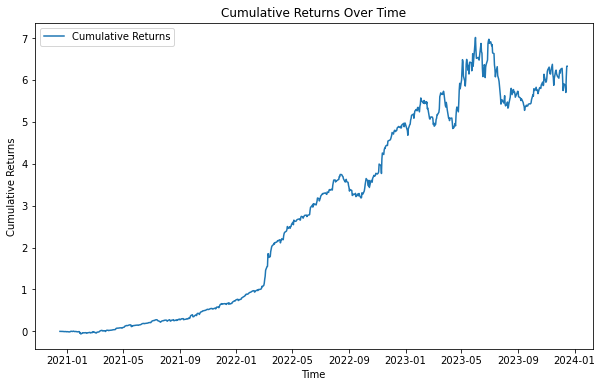

In [193]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

perf['cumulative_returns'] = (1 + perf['returns']).cumprod() - 1

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(perf['cumulative_returns'], label='Cumulative Returns')
plt.title('Cumulative Returns Over Time')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

In [50]:
perf['weights']

2007-03-19 20:00:00+00:00    [-0.04578134045004845, 0.49335554242134094, -0...
2007-03-20 20:00:00+00:00    [-0.04578134045004845, 0.49335554242134094, -0...
2007-03-21 20:00:00+00:00    [-0.04578134045004845, 0.49335554242134094, -0...
2007-03-22 20:00:00+00:00    [-0.04578134045004845, 0.49335554242134094, -0...
2007-03-23 20:00:00+00:00    [-0.04578134045004845, 0.49335554242134094, -0...
                                                   ...                        
2023-12-11 21:00:00+00:00    [0.05773433297872543, 0.32426488399505615, -0....
2023-12-12 21:00:00+00:00    [0.05773433297872543, 0.32426488399505615, -0....
2023-12-13 21:00:00+00:00    [0.05773433297872543, 0.32426488399505615, -0....
2023-12-14 21:00:00+00:00    [0.05773433297872543, 0.32426488399505615, -0....
2023-12-15 21:00:00+00:00    [0.05773433297872543, 0.32426488399505615, -0....
Name: weights, Length: 4220, dtype: object

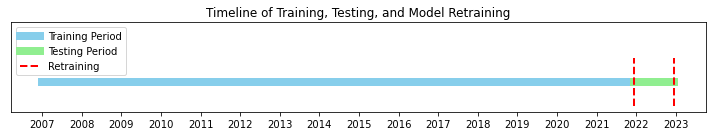

In [51]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Define the dates
start_date = datetime(2007, 1, 3)
retraining_dates = [datetime(2021, 12, 15), datetime(2022, 12, 15)]
test_start_date = datetime(2021, 12, 15)
end_date = datetime(2022, 12, 15)

# Plotting
fig, ax = plt.subplots(figsize=(10, 2))

# Highlight the training period
ax.plot([start_date, test_start_date], [1, 1], color="skyblue", linewidth=8, label='Training Period')

# Highlight the testing period
ax.plot([test_start_date, end_date], [1, 1], color="lightgreen", linewidth=8, label='Testing Period')

# Mark the retraining dates
for date in retraining_dates:
    plt.plot([date, date], [0.8, 1.2], color="red", linestyle='--', linewidth=2)

# Adding annotations for retraining dates
for date in retraining_dates:
    ax.text(date, 1.25, '', ha='center', color='red')

# Adjust the plot
ax.set_ylim(0.75, 1.5)
ax.yaxis.set_visible(False)  # Hide the y-axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Adding labels and title
plt.title('Timeline of Training, Testing, and Model Retraining')

# Adding custom legend
handles, labels = ax.get_legend_handles_labels()
custom_lines = [plt.Line2D([0], [0], color="skyblue", lw=8),
                plt.Line2D([0], [0], color="lightgreen", lw=8),
                plt.Line2D([0], [0], color="red", linestyle='--', lw=2)]
plt.legend(custom_lines, ['Training Period', 'Testing Period', 'Retraining'])

plt.tight_layout()
plt.show()
